In [6]:
#!/usr/bin/env python
# coding: utf-8

# load a bunch of stuff
from __future__ import division
# load
import cantera as ct
import numpy as np
import scipy
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
plt.switch_backend('agg')  # needed for saving figures
import csv
from pydas.dassl import DASSL
import os
import rmgpy
import rmg
import re
import operator
import pandas as pd
import pylab
from cycler import cycler
import seaborn as sns
import os
import multiprocessing

In [7]:
# this chemkin file is from the cti generated by rmg
# gas = ct.Solution('original/base_modified_pt.yaml', 'gas')
# surf = ct.Interface('original/base_modified_pt.yaml', 'surface1', [gas])
gas = ct.Solution('bm/base_bm.yaml', 'gas')
surf = ct.Interface('bm/base_bm.yaml', 'surface1', [gas])

print("This mechanism contains {} gas reactions and {} surface reactions".format(gas.n_reactions, surf.n_reactions))

i_ar = gas.species_index('Ar')
i_ch4 = gas.species_index('CH4(2)')
i_o2 = gas.species_index('O2(3)')
i_co2 = gas.species_index('CO2(4)')
i_h2o = gas.species_index('H2O(5)')
i_h2 = gas.species_index('H2(6)')
i_co = gas.species_index('CO(7)')

# unit conversion factors to SI
mm = 0.001
cm = 0.01
ms = mm
minute = 60.0

#######################################################################
# Input Parameters
#######################################################################
t_in = 800  # K - in the paper, it was ~698.15K at the start of the cat surface and ~373.15 for the gas inlet temp
t_cat = t_in
length = 70 * mm  # Reactor length- m
diam = 16.5*mm  # Reactor diameter - in m
area = (diam/2.0)**2*np.pi  # Reactor cross section area (area of tube) in m^2
porosity = 0.81  # Monolith channel porosity, from Horn ref 17 sec 2.2.2
cat_area_per_vol = 16000  # I made this up, in m-1. 4500 is lowest that "work" for all base
flow_rate = 4.7  # slpm
flow_rate = flow_rate*.001/60  # m^3/s
tot_flow = 0.208  # from Horn 2007, constant inlet flow rate in mol/min, equivalent to 4.7 slpm
velocity = flow_rate/area  # m/s
# The PFR will be simulated by a chain of 'NReactors' stirred reactors.
NReactors = 7001

on_catalyst = 1000  # catalyst length 10mm, but it doesn't say where.  let's guess at 1 cm?
off_catalyst = 2000
dt = 1.0

reactor_len = length/(NReactors-1)
rvol = area * reactor_len * porosity
# catalyst area in one reactor
cat_area = cat_area_per_vol * rvol


def plotZoom(a):
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a

    fig, axs = plt.subplots(1, 2)
    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))

    for i in range(len(gas_out[0, :])):
        if i != i_ar:
            if gas_out[:, i].max() > 5.e-3:
                #             print(gas_names[i])
                axs[0].plot(dist_array, gas_out[:, i], label=gas_names[i])
                species_name = gas_names[i]
                if species_name.endswith(')'):
                    if species_name[-3] == '(':
                        species_name = species_name[0:-3]
                    else:
                        species_name = species_name[0:-4]
                if species_name == "O2":
                    axs[0].annotate("O$_2$", fontsize=18, color='y',
                                    xy=(dist_array[1100], gas_out[:, i][1100] + gas_out[:, i][1100] / 100.0),
                                    va='bottom', ha='center')
                elif species_name == "CO2":
                    axs[0].annotate("CO$_2$", fontsize=18, color='c',
                                    xy=(dist_array[2400], gas_out[:, i][2400] + gas_out[:, i][2400] / 10.0), va='bottom',
                                    ha='center')
                elif species_name == "CO":
                    axs[0].annotate("CO", fontsize=18, color='g', xy=(dist_array[2100], gas_out[:, i][2100] + 0.001),
                                    va='bottom', ha='center')
                elif species_name == "H2":
                    axs[0].annotate("H$_2$", fontsize=18, color='k', xy=(dist_array[2200], gas_out[:, i][2200] - 0.001),
                                    va='top', ha='center')
                elif species_name == "CH4":
                    axs[0].annotate("CH$_4$", fontsize=18, color='b',
                                    xy=(dist_array[1100], gas_out[:, i][1100] + gas_out[:, i][1100] / 100.0),
                                    va='bottom', ha='center')
                elif species_name == "H2O":
                    axs[0].annotate("H$_2$O", fontsize=18, color='r',
                                    xy=(dist_array[2100], gas_out[:, i][2100] + gas_out[:, i][2100] / 40.0 + 0.001), va='bottom',
                                    ha='center')
                else:
                    axs[0].annotate(species_name, fontsize=18,
                                    xy=(dist_array[-1], gas_out[:, i][-1] + gas_out[:, i][-1] / 10.0), va='top',
                                    ha='center')
            else:
                axs[0].plot(0, 0)

    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))
    ax2 = axs[0].twinx()
    ax2.plot(dist_array, T_array, label='temperature', color='r', linestyle=':')
    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))

    axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.2], linestyle='--', color='xkcd:grey')
    axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.2], linestyle='--', color='xkcd:grey')
    axs[0].annotate("catalyst", fontsize=18, xy=(dist_array[on_catalyst], 0.175), va='bottom', ha='left')
    axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [600.0, 2000], linestyle='--', color='xkcd:grey')
    axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [600.0, 2000], linestyle='--', color='xkcd:grey')
    axs[1].annotate("catalyst", fontsize=18, xy=(dist_array[on_catalyst], 1800), va='bottom', ha='left')

    for item in (
            axs[0].get_xticklabels() + axs[0].get_yticklabels() + ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(18)

    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=4)
    axs[0].set_ylim(0., 0.1)
    axs[1].set_ylim(600.0, 2000)
    axs[0].set_xlim(8, 25)
    axs[1].set_xlim(8, 25)
    axs[0].set_xlabel('Distance (mm)', fontsize=22)
    axs[1].set_xlabel('Distance (mm)', fontsize=22)  # axs[0,1].set_xlabel('time (s)'); axs[1,1].set_xlabel('time (s)')
    axs[0].set_ylabel('flow/ mol/min', fontsize=22)
    ax2.set_ylabel('Temperature (K)', fontsize=22)
    ax2.set_ylim(600, 2000)
    ax2.set_xlim(8, 25)
    fig.delaxes(axs[1])  # THIS DELETES THE EXTRA SUBPLOT!
    fig.set_figheight(6)
    fig.set_figwidth(24)

    for n in range(len(gas_names)):
        if gas_names[n] == 'CH4(2)':
            c_in = gas_out[0][n]
        if gas_names[n] == 'O2(3)':
            o_in = gas_out[0][n]
    ratio = c_in / (o_in * 2)
    ratio = round(ratio, 1)

    out_dir = 'figures'
    os.path.exists(out_dir) or os.makedirs(out_dir)


def plotSurf(a):
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a

    fig, axs = plt.subplots(1, 2)
    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))

    for i in range(len(gas_out[0, :])):
        if i != i_ar:
            if gas_out[:, i].max() > 5.e-3:
                axs[0].plot(dist_array, gas_out[:, i], label=gas_names[i])
                species_name = gas_names[i]
                if species_name.endswith(')'):
                    if species_name[-3] == '(':
                        species_name = species_name[0:-3]
                    else:
                        species_name = species_name[0:-4]
                if species_name == "O2":
                    axs[0].annotate("O$_2$", fontsize=18,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 100.0),
                                    va='bottom', ha='center')
                elif species_name == "CO2":
                    axs[0].annotate("CO$_2$", fontsize=18,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 10.0), va='top',
                                    ha='center')
                elif species_name == "CO":
                    axs[0].annotate("CO", fontsize=18, xy=(dist_array[2200], gas_out[:, i][2200] + 0.001),
                                    va='bottom', ha='center')
                elif species_name == "CH2O":
                    axs[0].annotate("CH$_2$O", fontsize=18, xy=(dist_array[2200], gas_out[:, i][2200] + 0.001),
                                    va='bottom', ha='center')
                elif species_name == "CH4":
                    axs[0].annotate("CH$_4$", fontsize=18,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 100.0),
                                    va='bottom', ha='center')
                elif species_name == "H2O":
                    axs[0].annotate("H$_2$O", fontsize=18,
                                    xy=(dist_array[2200], gas_out[:, i][2200] + gas_out[:, i][2200] / 40.0), va='top',
                                    ha='center')
                else:
                    axs[0].annotate(species_name, fontsize=18,
                                    xy=(dist_array[-1], gas_out[:, i][-1] + gas_out[:, i][-1] / 10.0), va='top',
                                    ha='center')
            else:
                axs[0].plot(0, 0)

    axs[1].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))
    # Plot two temperatures (of gas-phase and surface vs only surface.)
    for i in range(len(surf_out[0, :])):
        if surf_out[:, i].max() > 5.e-3:
            axs[1].semilogy(dist_array, surf_out[:, i], label=surf_names[i])
    axs[0].set_prop_cycle(cycler('color', ['m', 'g', 'b', 'y', 'c', 'r', 'k', 'g']))

    axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.2], linestyle='--', color='xkcd:grey')
    axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.2], linestyle='--', color='xkcd:grey')
    axs[0].annotate("catalyst", fontsize=18, xy=(dist_array[on_catalyst], 0.175), va='bottom', ha='left')
    axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 1.2], linestyle='--', color='xkcd:grey')
    axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 1.2], linestyle='--', color='xkcd:grey')
    axs[1].annotate("catalyst", fontsize=18, xy=(dist_array[on_catalyst], 1.1), va='bottom', ha='left')

    for item in (
            axs[0].get_xticklabels() + axs[0].get_yticklabels() + axs[1].get_xticklabels() + axs[1].get_yticklabels()):
        item.set_fontsize(18)

    axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=2)
    axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=False, shadow=False, ncol=4)
    axs[0].set_ylim(0., 0.1)
    axs[1].set_ylim(1e-10, 1.2)
    axs[0].set_xlim(5, 25)
    axs[1].set_xlim(9, 21)
    axs[0].set_xlabel('Distance (mm)', fontsize=22)
    axs[1].set_xlabel('Distance (mm)', fontsize=22)
    axs[0].set_ylabel('flow/ mol/min', fontsize=22)
    axs[1].set_ylabel('Site fraction', fontsize=22)
    fig.delaxes(axs[0])  # THIS DELETES THE EXTRA SUBPLOT!

    fig.set_figheight(6)
    fig.set_figwidth(18)

    for n in range(len(gas_names)):
        if gas_names[n] == 'CH4(2)':
            c_in = gas_out[0][n]
        if gas_names[n] == 'O2(3)':
            o_in = gas_out[0][n]
    ratio = c_in / (o_in * 2)
    ratio = round(ratio, 1)

    out_dir = 'figures'
    os.path.exists(out_dir) or os.makedirs(out_dir)
    fig.clf()


def monolithFull(gas, surf, temp, mol_in, verbose=False, sens=False):
    """
    Verbose prints out values as you go along
    Sens is for sensitivity, in the form [perturbation, reaction #]
    """
    ch4, o2, ar = mol_in
    ratio = ch4/(2*o2)
    ratio = round(ratio, 1)
    ch4 = str(ch4)
    o2 = str(o2)
    ar = str(ar)
    X = str('CH4(2):' + ch4 + ', O2(3):' + o2 + ', Ar:' + ar)
    gas.TPX = 273.15, ct.one_atm, X  # need to initialize mass flow rate at STP
    mass_flow_rate = flow_rate * gas.density_mass
    gas.TPX = temp, ct.one_atm, X
    temp_cat = temp
    surf.TP = temp_cat, ct.one_atm
    surf.coverages = 'X(1):1.0'
    gas.set_multiplier(1.0)

    TDY = gas.TDY
    cov = surf.coverages

    if verbose is True:
        print('  distance(mm)   X_CH4        X_O2        X_H2       X_CO       X_H2O       X_CO2')

    # create a new reactor
    gas.TDY = TDY
    r = ct.IdealGasReactor(gas)
    r.volume = rvol

    # create a reservoir to represent the reactor immediately upstream. Note
    # that the gas object is set already to the state of the upstream reactor
    upstream = ct.Reservoir(gas, name='upstream')

    # create a reservoir for the reactor to exhaust into. The composition of
    # this reservoir is irrelevant.
    downstream = ct.Reservoir(gas, name='downstream')

    # Add the reacting surface to the reactor. The area is set to the desired
    # catalyst area in the reactor.
    rsurf = ct.ReactorSurface(surf, r, A=cat_area)

    # The mass flow rate into the reactor will be fixed by using a
    # MassFlowController object.
    # mass_flow_rate = velocity * gas.density_mass * area  # kg/s
    # mass_flow_rate = flow_rate * gas.density_mass
    m = ct.MassFlowController(upstream, r, mdot=mass_flow_rate)

    # We need an outlet to the downstream reservoir. This will determine the
    # pressure in the reactor. The value of K will only affect the transient
    # pressure difference.
    v = ct.PressureController(r, downstream, master=m, K=1e-5)

    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 12

    # set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-10
    sim.atol = 1.0e-20

    gas_names = gas.species_names
    surf_names = surf.species_names
    gas_out = []
    surf_out = []
    dist_array = []
    T_array = []

    surf.set_multiplier(0.0)  # no surface reactions until the gauze
    for n in range(NReactors):
        # Set the state of the reservoir to match that of the previous reactor
        gas.TDY = r.thermo.TDY
        upstream.syncState()
        if n == on_catalyst:
            surf.set_multiplier(1.0)
            if sens is not False:
                surf.set_multiplier(1.0 + sens[0], sens[1])
        if n == off_catalyst:
            surf.set_multiplier(0.0)
        sim.reinitialize()
        sim.advance_to_steady_state()
        dist = n * reactor_len * 1.0e3  # distance in mm
        dist_array.append(dist)
        T_array.append(surf.T)
        # print "mass_flow_rate", mass_flow_rate,  v.mdot(sim.time), "kg/s"
        kmole_flow_rate = mass_flow_rate / gas.mean_molecular_weight  # kmol/s
        gas_out.append(1000 * 60 * kmole_flow_rate * gas.X.copy())  # molar flow rate in moles/minute
        surf_out.append(surf.X.copy())

        # make reaction diagrams
        out_dir = 'rxnpath_bma'
        os.path.exists(out_dir) or os.makedirs(out_dir)
        elements = ['H', 'O']
        locations_of_interest = [1000, 1150, 1160, 1183, 1196, 1999]
        if sens is False:
            for l in locations_of_interest:
                if n == l:
                    location = str(n / 100)

                    diagram = ct.ReactionPathDiagram(surf, 'X')
                    diagram.title = 'rxn path'
                    diagram.label_threshold = 1e-9
                    dot_file = out_dir + '/rxnpath-' + str(ratio) + '-x-' + location + 'mm.dot'
                    img_file = out_dir + '/rxnpath-' + str(ratio) + '-x-' + location + 'mm.png'
                    img_path = os.path.join(out_dir, img_file)
                    diagram.write_dot(dot_file)
                    os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))

                    for element in elements:
                        diagram = ct.ReactionPathDiagram(surf, element)
                        diagram.title = element + 'rxn path'
                        diagram.label_threshold = 1e-9
                        dot_file = out_dir + '/rxnpath-' + str(ratio) + '-surf-' + location + 'mm-' + element + '.dot'
                        img_file = out_dir + '/rxnpath-' + str(ratio) + '-surf-' + location + 'mm-' + element + '.png'
                        img_path = os.path.join(out_dir, img_file)
                        diagram.write_dot(dot_file)
                        os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
        else:
            pass

        if verbose is True:
            if not n % 100:
                print('  {0:10f}  {1:10f}  {2:10f}  {3:10f} {4:10f} {5:10f} {6:10f}'.format(dist, *gas[
                    'CH4(2)', 'O2(3)', 'H2(6)', 'CO(7)', 'H2O(5)', 'CO2(4)'].X * 1000 * 60 * kmole_flow_rate))

    gas_out = np.array(gas_out)
    surf_out = np.array(surf_out)
    gas_names = np.array(gas_names)
    surf_names = np.array(surf_names)
    data_out = gas_out, surf_out, gas_names, surf_names, dist_array, T_array
    return data_out


ratio = 1.0
fo2 = 1 / (2. * ratio + 1 + 79 / 21)
fch4 = 2 * fo2 * ratio
far = 79 * fo2 / 21
ratio_in = [fch4, fo2, far]

a = monolithFull(gas, surf, t_in, ratio_in)
gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a

def deriv(p):
    deriv = []
    for x in range(7000):
        deriv.append((p[x+1] - p[x])/.01)
    deriv.append(0.)
    return deriv

methane = gas_out[:,3]
oxygen = gas_out[:,4]
hydrogen = gas_out[:,7]
co2 = gas_out[:,5]
co = gas_out[:,8]
h2o = gas_out[:,6]

d_ch4 = deriv(methane)
d_o2 = deriv(oxygen)
d_h2 = deriv(hydrogen)
d_co2 = deriv(co2)
d_co = deriv(co)
d_h2o = deriv(h2o)


plt.figure(figsize=(6,5))
plt.plot(dist_array,d_ch4,color='green')
plt.plot(dist_array,d_o2,color='orange')
plt.plot(dist_array,d_h2,color='k')
plt.plot(dist_array,d_co2,color='blue')
plt.plot(dist_array,d_co,color='limegreen')
plt.plot(dist_array,d_h2o,color='dodgerblue')

plt.annotate("CH$_4$", fontsize=18, color='g',
            xy=(dist_array[1140], -.15),
            va='bottom', ha='center')
plt.annotate("O$_2$", fontsize=18, color='orange',
            xy=(dist_array[1113], -.17),
            va='bottom', ha='center')
plt.annotate("H$_2$", fontsize=18, color='k',
            xy=(dist_array[1144], .15),
            va='bottom', ha='center')
plt.annotate("CO", fontsize=18, color='limegreen',
            xy=(dist_array[1137], .03),
            va='bottom', ha='center')
plt.annotate("CO$_2$", fontsize=18, color='blue',
            xy=(dist_array[1125], -0.03),
            va='bottom', ha='center')
plt.annotate("H$_2$O", fontsize=18, color='dodgerblue',
            xy=(dist_array[1105], .1),
            va='bottom', ha='center')

plt.xlabel('Position (mm)', fontsize=22)
plt.ylabel('d Flow/dx', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(np.arange(10.5,12.5,0.5))
plt.yticks(np.arange(-.2,.25, .1))
plt.xlim(10.5,12.)
plt.savefig('paperplots/deriv.pdf',bbox_inches='tight',dpi=300)
plt.clf()

temp_profile = np.array([
        [0.,373.15],
        [1.,373.15],
        [2.,373.15],
        [3.,373.15],
        [4.,373.15],
        [5.,373.15],
        [6.,413.15],
        [7.,448.15],
        [8.,473.15],
        [9.,548.15],
        [10.,648.15],
        [11.,963.15],
        [12.,1133.15],
        [13.,1173.15],
        [14.,1163.15],
        [15.,1123.15],
        [16.,1098.15],
        [17.,1073.15],
        [18.,1068.15],
        [19.,1063.15],
        [20.,1048.15],
        [21.,1033.15],
        [22.,1028.15],
        [23.,1023.15],
        [24.,1023.15],
        [25.,1023.15],])

ch4_in = 21/71*.208
ch4_profile = np.array([
        [0.,ch4_in],
        [1.,ch4_in],
        [2.,ch4_in],
        [3.,ch4_in],
        [4.,ch4_in],
        [5.,ch4_in],
        [6.,ch4_in],
        [7.,ch4_in],
        [8.,ch4_in],
        [9.,ch4_in],
        [10.,ch4_in],
        [10.25,0.059],
        [10.5,0.048],
        [10.75,0.041],
        [11.,0.036],
        [11.5,0.028],
        [12.,0.0225],
        [12.25,0.022],
        [12.5,0.021],
        [13.,0.021],
        [13.5,0.022],
        [14.,0.022],
        [14.5,0.021],
        [15.,0.019],
        [15.5,0.017],
        [16.,0.016],
        [17.,0.016],
        [18.,0.015],
        [19.,0.015],
        [20.,0.015],
        [21.,0.014],
        [22.,0.014],
        [23.,0.014],
        [24.,0.014],
        [25.,0.014],])

o2_in = (1 / (2. + 1 + 79 / 21)) * .208
o2_profile = np.array([
        [0.,o2_in],
        [1.,o2_in],
        [2.,o2_in],
        [3.,o2_in],
        [4.,o2_in],
        [5.,o2_in],
        [6.,o2_in],
        [7.,o2_in],
        [8.,o2_in],
        [9.,o2_in],
        [9.5,o2_in],
        [9.75,o2_in],
        [10.,o2_in],
        [10.1,0.028],
        [10.25,0.022],
        [10.5,0.013],
        [10.75,0.008],
        [11.,0.004],
        [11.25,0.001],
        [11.5,0.],
        [12.,0.],
        [13.,0.],
        [14.,0.],
        [15.,0.],
        [16.,0.],
        [17.,0.],
        [18.,0.],
        [19.,0.],
        [20.,0.],
        [21.,0.],
        [22.,0.],
        [23.,0.],
        [24.,0.],
        [25.,0.],])

h2_profile = np.array([
        [0.,0],
        [1.,0],
        [2.,0],
        [3.,0],
        [4.,0],
        [5.,0],
        [6.,0],
        [7.,0],
        [8.,0],
        [9.,0],
        [10.,0],
        [10.5,0.015],
        [11.,0.034],
        [12.,0.051],
        [13.,0.065],
        [14.,0.071],
        [15.,0.083],
        [16.,0.089],
        [17.,0.0895],
        [18.,0.09],
        [19.,0.0905],
        [20.,0.091],
        [21.,0.092],
        [22.,0.092],
        [23.,0.092],
        [24.,0.092],
        [25.,0.092],])

co_profile = np.array([
        [0.,0],
        [1.,0],
        [2.,0],
        [3.,0],
        [4.,0],
        [5.,0],
        [6.,0],
        [7.,0],
        [8.,0],
        [9.,0],
        [10.,0],
        [10.5,0.015],
        [11.,0.026],
        [12.,0.035],
        [13.,0.04],
        [14.,0.036],
        [15.,0.04],
        [16.,0.044],
        [17.,0.045],
        [18.,0.045],
        [19.,0.045],
        [20.,0.045],
        [21.,0.045],
        [22.,0.045],
        [23.,0.045],
        [24.,0.045],
        [25.,0.045],])

h2o_profile = np.array([
        [0.,0],
        [1.,0],
        [2.,0],
        [3.,0],
        [4.,0],
        [5.,0],
        [6.,0],
        [7.,0],
        [8.,0],
        [9.,0],
        [10.,0],
        [10.5,0.015],
        [11.,0.025],
        [11.5,0.026],
        [12.,0.025],
        [12.5,0.022],
        [13.,0.019],
        [14.,0.011],
        [15.,0.009],
        [16.,0.009],
        [17.,0.009],
        [18.,0.008],
        [19.,0.008],
        [20.,0.008],
        [21.,0.008],
        [22.,0.008],
        [23.,0.008],
        [24.,0.008],
        [25.,0.008],])

co2_profile = np.array([
        [0.,0],
        [1.,0],
        [2.,0],
        [3.,0],
        [4.,0],
        [5.,0],
        [6.,0],
        [7.,0],
        [8.,0],
        [9.,0],
        [10.,0],
        [11.,0.002],
        [12.,0.002],
        [12.5,0.002],
        [13.,0.002],
        [14.,0.002],
        [15.,0.002],
        [16.,0.002],
        [17.,0.002],
        [18.,0.002],
        [19.,0.002],
        [20.,0.002],
        [21.,0.002],
        [22.,0.002],
        [23.,0.002],
        [24.,0.002],
        [25.,0.002],])


from scipy.interpolate import interp1d

dist = np.linspace(0,25,2501)
ch4 = interp1d(ch4_profile[:,0],ch4_profile[:,1],kind='cubic')
o2 = interp1d(o2_profile[:,0],o2_profile[:,1],kind='cubic')
h2 = interp1d(h2_profile[:,0],h2_profile[:,1],kind='cubic')
co = interp1d(co_profile[:,0],co_profile[:,1],kind='cubic')
h2o = interp1d(h2o_profile[:,0],h2o_profile[:,1],kind='cubic')
co2 = interp1d(co2_profile[:,0],co2_profile[:,1],kind='cubic')
temp = interp1d(temp_profile[:,0],temp_profile[:,1],kind='cubic')

plt.plot(dist,ch4(dist),color='g')
plt.annotate("CH$_4$", fontsize=18, color='g',
            xy=(dist_array[700], .062),
            va='bottom', ha='center')
plt.plot(dist,o2(dist),color='orange')
plt.annotate("O$_2$", fontsize=18, color='orange',
            xy=(dist_array[700], .032),
            va='bottom', ha='center')
plt.plot(dist,h2(dist),color='k')
plt.annotate("H$_2$", fontsize=18, color='k',
            xy=(dist_array[2300], .072),
            va='bottom', ha='center')
plt.plot(dist,co(dist),color='limegreen')
plt.annotate("CO", fontsize=18, color='limegreen',
            xy=(dist_array[2300], .03),
            va='bottom', ha='center')
plt.plot(dist,co2(dist),color='blue')
plt.annotate("CO$_2$", fontsize=18, color='blue',
            xy=(dist_array[2200], .002),
            va='bottom', ha='center')
plt.plot(dist,h2o(dist),color='dodgerblue')
plt.annotate("H$_2$O", fontsize=18, color='dodgerblue',
            xy=(dist_array[1600], .01),
            va='bottom', ha='center')
plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle='--', color='xkcd:grey')
plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle='--', color='xkcd:grey')
plt.annotate("catalyst", fontsize=18, xy=(dist_array[1500], 0.095), va='center', ha='center')

plt.ylabel('Flow (mol/min)', fontsize=22)
plt.xlabel('Position (mm)', fontsize=22)
plt.ylim((0,0.1))
plt.xlim((5,25))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(np.arange(6,26,2))

ax2 = plt.twinx()
ax2.plot(dist,temp(dist), ':', color='r')
ax2.set_ylim(300, 2000)
ax2.annotate("T",fontsize=18, color='r',
             xy=(dist_array[2300], 1310),
             va='top', ha='center')
ax2.set_ylabel('Temperature (K)', fontsize=22)
for item in (ax2.get_yticklabels()):
             item.set_fontsize(18)
plt.savefig('paperplots/horn_data.pdf',bbox_inches='tight',dpi=300)
plt.clf()


# plotting ch4
plt.plot(dist_array,gas_out[:,3], label=gas_names[3],color='g')
plt.annotate("CH$_4$", fontsize=18, color='g',
            xy=(dist_array[700], gas_out[:, 3][500] + gas_out[:, 3][500] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,ch4(dist),'--',color='g')
# plotting o2
plt.plot(dist_array,gas_out[:,4], label=gas_names[4],color='orange')
plt.annotate("O$_2$", fontsize=18, color='orange',
            xy=(dist_array[700], gas_out[:, 4][500] + gas_out[:, 4][500] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,o2(dist),'--',color='orange')

plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.annotate("catalyst", fontsize=18, xy=(dist_array[1500], 0.095), va='center', ha='center')

plt.ylabel('Flow (mol/min)', fontsize=22)
plt.xlabel('Position (mm)', fontsize=22)
plt.ylim((0,0.1))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(np.arange(6,26,2))

ax2 = plt.twinx()
ax2.plot(dist,temp(dist), '--', color='r')
ax2.plot(dist_array,T_array,color='r')
ax2.annotate("T",fontsize=18, color='r',
             xy=(dist_array[2300], T_array[2300] -150),
             va='top', ha='center')
ax2.set_ylim(300, 2000)
ax2.set_ylabel('Temperature (K)', fontsize=22)
for item in (ax2.get_yticklabels()):
             item.set_fontsize(18)

plt.xlim((5,25))  # cutting off where the horn paper cuts off the plots
plt.savefig('paperplots/compare_ch4_o2_temp.pdf',bbox_inches='tight',dpi=300)
plt.clf()


# plotting h2
plt.plot(dist_array,gas_out[:,7], label=gas_names[7],color='k')
plt.annotate("H$_2$", fontsize=18, color='k',
            xy=(dist_array[2200], gas_out[:, 7][2200] + gas_out[:, 7][2200] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,h2(dist),'--',color='k')
# plotting co
plt.plot(dist_array,gas_out[:,8], label=gas_names[8],color='limegreen')
plt.annotate("CO", fontsize=18, color='limegreen',
            xy=(dist_array[1800], gas_out[:, 8][1800] + gas_out[:, 8][1800] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,co(dist),'--',color='limegreen')

plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.annotate("catalyst", fontsize=18, xy=(dist_array[1500], 0.095), va='center', ha='center')

plt.ylabel('Flow (mol/min)', fontsize=22)
plt.xlabel('Position (mm)', fontsize=22)
plt.ylim((0,0.1))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(np.arange(6,26,2))

plt.xlim((5,25))  # cutting off where the horn paper cuts off the plots
plt.savefig('paperplots/compare_h2_co.pdf',bbox_inches='tight',dpi=300)
plt.clf()


# plotting h2o
plt.plot(dist_array,gas_out[:,6], label=gas_names[6],color='dodgerblue')
plt.annotate("H$_2$O", fontsize=18, color='dodgerblue',
            xy=(dist_array[2200], gas_out[:, 6][2200] -.01),
            va='bottom', ha='center')
plt.plot(dist,h2o(dist),'--',color='dodgerblue')
# plotting co2
plt.plot(dist_array,gas_out[:,5], label=gas_names[5],color='blue')
plt.annotate("CO$_2$", fontsize=18, color='blue',
            xy=(dist_array[1400], .009),
            va='bottom', ha='center')
plt.plot(dist,co2(dist),'--',color='blue')

plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.annotate("catalyst", fontsize=18, xy=(dist_array[1500], 0.095), va='center', ha='center')

plt.ylabel('Flow (mol/min)', fontsize=22)
plt.xlabel('Position (mm)', fontsize=22)
plt.ylim((0,0.1))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(np.arange(6,26,2))

plt.xlim((5,25))  # cutting off where the horn paper cuts off the plots
plt.savefig('paperplots/compare_h2o_co2.pdf',bbox_inches='tight',dpi=300)
plt.clf()


# plotting ch4
plt.plot(dist_array,gas_out[:,3], label=gas_names[3],color='g')
plt.annotate("CH$_4$", fontsize=18, color='g',
            xy=(dist_array[700], gas_out[:, 3][500] + gas_out[:, 3][500] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,ch4(dist),'--',color='g')
# plotting o2
plt.plot(dist_array,gas_out[:,4], label=gas_names[4],color='orange')
plt.annotate("O$_2$", fontsize=18, color='orange',
            xy=(dist_array[700], gas_out[:, 4][500] + gas_out[:, 4][500] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,o2(dist),'--',color='orange')
# plotting h2
plt.plot(dist_array,gas_out[:,7], label=gas_names[7],color='k')
plt.annotate("H$_2$", fontsize=18, color='k',
            xy=(dist_array[2200], gas_out[:, 7][2200] + gas_out[:, 7][2200] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,h2(dist),'--',color='k')
# plotting co
plt.plot(dist_array,gas_out[:,8], label=gas_names[8],color='limegreen')
plt.annotate("CO", fontsize=18, color='limegreen',
            xy=(dist_array[1800], gas_out[:, 8][1800] + gas_out[:, 8][1800] / 100.0),
            va='bottom', ha='center')
plt.plot(dist,co(dist),'--',color='limegreen')
# plotting h2o
plt.plot(dist_array,gas_out[:,6], label=gas_names[6],color='dodgerblue')
plt.annotate("H$_2$O", fontsize=18, color='dodgerblue',
            xy=(dist_array[2200], gas_out[:, 6][2200] -.01),
            va='bottom', ha='center')
plt.plot(dist,h2o(dist),'--',color='dodgerblue')
# plotting co2
plt.plot(dist_array,gas_out[:,5], label=gas_names[5],color='blue')
plt.annotate("CO$_2$", fontsize=18, color='blue',
            xy=(dist_array[1400], .009),
            va='bottom', ha='center')
plt.plot(dist,co2(dist),'--',color='blue')

plt.plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
plt.annotate("catalyst", fontsize=18, xy=(dist_array[1500], 0.095), va='center', ha='center')

plt.ylabel('Flow (mol/min)', fontsize=22)
plt.xlabel('Position (mm)', fontsize=22)
plt.ylim((0,0.1))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(np.arange(6,26,2))

plt.xlim((5,25))  # cutting off where the horn paper cuts off the plots
plt.savefig('paperplots/all_compare.pdf',bbox_inches='tight',dpi=300)

plt.clf()


fig, axs = plt.subplots(3, 1)

# plotting ch4
axs[0].plot(dist_array,gas_out[:,3], label=gas_names[3],color='g')
axs[0].annotate("CH$_4$", fontsize=18, color='g',
            xy=(dist_array[700], gas_out[:, 3][500] + gas_out[:, 3][500] / 100.0),
            va='bottom', ha='center')
axs[0].plot(dist,ch4(dist),'--',color='g')
# plotting o2
axs[0].plot(dist_array,gas_out[:,4], label=gas_names[4],color='orange')
axs[0].annotate("O$_2$", fontsize=18, color='orange',
            xy=(dist_array[700], gas_out[:, 4][500] + gas_out[:, 4][500] / 100.0),
            va='bottom', ha='center')
axs[0].plot(dist,o2(dist),'--',color='orange')

axs[0].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
axs[0].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
axs[0].annotate("catalyst", fontsize=18, xy=(dist_array[1500], 0.095), va='center', ha='center')

axs[0].set_ylabel('Flow (mol/min)', fontsize=22)
axs[0].set_ylim((0,0.1))
for item in (axs[0].get_xticklabels()):
             item.set_fontsize(18)
for item in (axs[0].get_yticklabels()):
             item.set_fontsize(18)
axs[0].set_xticks(np.arange(6,26,2))

ax2 = axs[0].twinx()
ax2.plot(dist,temp(dist), '--', color='r')
ax2.plot(dist_array,T_array,color='r')
ax2.annotate("T (K)",fontsize=18, color='r',
             xy=(dist_array[2300], T_array[2300] -150),
             va='top', ha='center')
ax2.set_ylim(300, 2000)
for item in (ax2.get_yticklabels()):
             item.set_fontsize(18)
axs[0].set_xlim((5,25))

# plotting h2
axs[1].plot(dist_array,gas_out[:,7], label=gas_names[7],color='k')
axs[1].annotate("H$_2$", fontsize=18, color='k',
            xy=(dist_array[2200], 0.0575),
            va='bottom', ha='center')
axs[1].plot(dist,h2(dist),'--',color='k')
# plotting co
axs[1].plot(dist_array,gas_out[:,8], label=gas_names[8],color='limegreen')
axs[1].annotate("CO", fontsize=18, color='limegreen',
            xy=(dist_array[1800], gas_out[:, 8][1800] + gas_out[:, 8][1800] / 100.0 + 0.005),
            va='bottom', ha='center')
axs[1].plot(dist,co(dist),'--',color='limegreen')

axs[1].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
axs[1].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')

axs[1].set_ylabel('Flow (mol/min)', fontsize=22)
axs[1].set_ylim((0,0.1))
for item in (axs[1].get_xticklabels()):
             item.set_fontsize(18)
for item in (axs[1].get_yticklabels()):
             item.set_fontsize(18)
axs[1].set_xticks(np.arange(6,26,2))

axs[1].set_xlim((5,25))  # cutting off where the horn paper cuts off the plots

# plotting h2o
axs[2].plot(dist_array,gas_out[:,6], label=gas_names[6],color='dodgerblue')
axs[2].annotate("H$_2$O", fontsize=18, color='dodgerblue',
            xy=(dist_array[2200], 0.02),
            va='bottom', ha='center')
axs[2].plot(dist,h2o(dist),'--',color='dodgerblue')
# plotting co2
axs[2].plot(dist_array,gas_out[:,5], label=gas_names[5],color='blue')
axs[2].annotate("CO$_2$", fontsize=18, color='blue',
            xy=(dist_array[1225], .005),
            va='bottom', ha='center')
axs[2].plot(dist,co2(dist),'--',color='blue')

axs[2].plot([dist_array[on_catalyst], dist_array[on_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')
axs[2].plot([dist_array[off_catalyst], dist_array[off_catalyst]], [0, 0.1], linestyle=':', color='xkcd:grey')

axs[2].set_ylabel('Flow (mol/min)', fontsize=22)
axs[2].set_ylim((0,0.1))
for item in (axs[2].get_xticklabels()):
             item.set_fontsize(18)
for item in (axs[2].get_yticklabels()):
             item.set_fontsize(18)
axs[2].set_xticks(np.arange(6,26,2))

axs[2].set_xlim((5,25))  # cutting off where the horn paper cuts off the plots

axs[2].set_xlabel('Position (mm)', fontsize=22)
fig.set_figheight(10)
fig.set_figwidth(7)
plt.savefig('paperplots/all_compare_subplots.pdf',bbox_inches='tight',dpi=300)
plt.clf()


def simulationWorker(ratio):
    fo2 = 1 / (2. * ratio + 1 + 79 / 21)
    fch4 = 2 * fo2 * ratio
    far = 79 * fo2 / 21
    ratio_in = [fch4, fo2, far]  # mol fractions

    a = monolithFull(gas, surf, t_in, ratio_in)
    print("Finished simulation at a C/O ratio of {:.1f}".format(ratio))
    gas_out, surf_out, gas_names, surf_names, dist_array, T_array = a
    return [ratio, [gas_out, gas_names, dist_array, T_array]]


ratios = [.6, .7, .8, .9, 1., 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2., 2.2, 2.4, 2.6]  # 15 items
data = []
num_threads = len(ratios)
pool = multiprocessing.Pool(processes=num_threads)
data = pool.map(simulationWorker, ratios, 1)
pool.close()
pool.join()

end_temp = []
max_temp = []
dist_max_temp = []
ch4_in = []
ch4_out = []
ch4_conv = []
o2_conv = []
co_sel = []
co_out = []
h2_sel = []
h2_out = []
h2o_sel = []
h2o_out = []
co2_sel = []
co2_out = []
ratios_real = []
for r in data:
    for x in range(len(r[1][1])):
        if r[1][1][x] == 'CH4(2)':
            ch4_i = r[1][0][0][x]
            ch4_in.append(ch4_i)
            ch4_o = r[1][0][-1][x]
            ch4_out.append(ch4_o)
            ch4_depletion = ch4_i - ch4_o
            ch4_conv.append(ch4_depletion / ch4_i)
        if r[1][1][x] == 'O2(3)':
            o2_in = r[1][0][0][x]
            o2_out = r[1][0][-1][x]
            o2_conv.append((o2_in - o2_out) / o2_in)
    ratios_real.append(ch4_i / (2 * o2_in))
    end_temp.append(r[1][3][-1])
    max_temp.append(max(r[1][3]))
    dist_max_temp.append(r[1][2][r[1][3].index(max(r[1][3]))])

    for x in range(len(r[1][1])):
        if r[1][1][x] == 'Ar':
            ar = r[1][0][-1][x]
        if r[1][1][x] == 'CO(7)':
            co_o = r[1][0][-1][x]
            co_out.append(co_o)
            co_sel.append(co_o / ch4_depletion)
        if r[1][1][x] == 'H2O(5)':
            h2o_o = r[1][0][-1][x]
            h2o_out.append(h2o_o)
            h2o_sel.append(h2o_o / (ch4_depletion * 2))
        if r[1][1][x] == 'H2(6)':
            h2_o = r[1][0][-1][x]
            h2_out.append(h2_o)
            h2_sel.append(h2_o / (ch4_depletion * 2))
        if r[1][1][x] == 'CO2(4)':
            co2_o = r[1][0][-1][x]
            co2_out.append(co2_o)
            co2_sel.append(co2_o / ch4_depletion)

pch4_conv = [x *100 for x in ch4_conv]
po2_conv = [x * 100 for x in o2_conv]
# #horn data
o2_horn = [100] * 15
ch4_horn = [100,99,95,88,78,69,62,57,50,44,37,32,27,24,21]
t_horn_c = [1175,1000,820,790,780,775,770,768,765,760,755,750,740,730,725] #celcius
t_horn = [x + 275.13 for x in t_horn_c]


plt.figure(figsize=(6,5))
plt.plot(ratios_real, pch4_conv, 'bo-', label='CH4', color='g')
plt.annotate("CH$_4$", fontsize=18, color='g',xy=(1.6,60), va='top', ha='center')
plt.plot(ratios_real,ch4_horn, '--', color='g')
plt.plot(ratios_real, po2_conv, 'bo-', label='O2', color='orange')
plt.annotate("O$_2$", fontsize=18, color='orange',xy=(1.8,95), va='top', ha='center')
plt.plot(ratios_real,o2_horn, '--', color='orange')
plt.yticks(np.arange(0,106,10))
plt.ylabel('Exit conversion (%)', fontsize=22)
plt.xlabel('C/O Ratio', fontsize=22)
plt.xticks(np.arange(.6,2.7,0.4))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax2 = plt.twinx()
ax2.plot(ratios_real, end_temp, 'bo-', color='r')
ax2.set_ylim(900, 1900)
ax2.set_yticks(np.arange(900,2200,100))
for item in (ax2.get_yticklabels()):
             item.set_fontsize(13)
ax2.annotate("T",fontsize=18, color='r',
             xy=(1.3, 1150),
             va='top', ha='center')
ax2.set_ylabel('Temperature (K)', fontsize=22)
for item in (ax2.get_yticklabels()):
             item.set_fontsize(18)
ax2.plot(ratios_real,t_horn,'--',color='r')
plt.tight_layout()
plt.savefig('paperplots/conversion.pdf', bbox_inches='tight', dpi=300)
plt.clf()

pco_sel = [x *100 for x in co_sel]
ph2_sel = [x * 100 for x in h2_sel]
pco2_sel = [x * 100 for x in co2_sel]
ph2o_sel = [x * 100 for x in h2o_sel]

# horn data
horn_co = [88,90,93,94,95,95,94,94,93,92,91,90,89,88,87]
horn_h2 = [79,88,95,94,93,92,91,90,89,88,85,84,80,78,76]
horn_h2o = [21,12,5,6,7,8,9,10,11,12,15,16,20,22,24]
horn_co2 = [12,10,7,6,5,5,6,6,7,8,9,10,11,12,13]

plt.figure(figsize=(6,5))
plt.plot(ratios_real, pco_sel, 'bo-', label='CO', color='limegreen')
plt.annotate("CO", fontsize=18, color='limegreen',xy=(1.8,98), va='top', ha='center')
plt.plot(ratios_real,horn_co,'--',color='limegreen')
plt.plot(ratios_real, ph2_sel, 'bo-', label='H2', color='k')
plt.annotate("H$_2$", fontsize=18, color='k',xy=(0.8,75), va='top', ha='center')
plt.plot(ratios_real, pco2_sel, 'bo-', label='CO2', color='blue')
plt.plot(ratios_real,horn_h2,'--',color='k')
plt.annotate("CO$_2$", fontsize=18, color='blue',xy=(1.8,8), va='top', ha='center')
plt.plot(ratios_real,horn_co2,'--',color='blue')
plt.plot(ratios_real, ph2o_sel, 'bo-', label='H2O', color='dodgerblue')
plt.annotate("H$_2$O", fontsize=18, color='dodgerblue',xy=(1.,25), va='top', ha='center')
plt.ylabel('Exit Selectivity (%)', fontsize=18)
plt.plot(ratios_real,horn_h2o,'--',color='dodgerblue')
plt.xlabel('C/O Ratio', fontsize=22)
plt.xticks(np.arange(.6,2.7,0.4))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yticks(np.arange(0,110,10))
plt.tight_layout()
plt.savefig('paperplots/selectivity_comparison.pdf', bbox_inches='tight', dpi=300)
plt.clf()


plt.figure(figsize=(6,5))
plt.plot(ratios_real, pco_sel, 'bo-', label='CO', color='limegreen')
plt.annotate("CO", fontsize=18, color='limegreen',xy=(1.8,98), va='top', ha='center')
plt.plot(ratios_real,horn_co,'--',color='limegreen')
plt.plot(ratios_real, ph2_sel, 'bo-', label='H2', color='k')
plt.annotate("H$_2$", fontsize=18, color='k',xy=(0.8,75), va='top', ha='center')
plt.plot(ratios_real,horn_h2,'--',color='k')
plt.ylabel('Exit Selectivity (%)', fontsize=22)
plt.xlabel('C/O Ratio', fontsize=22)
plt.xticks(np.arange(.6,2.7,0.2))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yticks(np.arange(10,100,10))
plt.tight_layout()
plt.savefig('paperplots/selectivity_syngas.pdf', bbox_inches='tight', dpi=300)
plt.clf()


plt.figure(figsize=(6,5))
plt.plot(ratios_real, pco2_sel, 'bo-', label='CO2', color='blue')
plt.annotate("CO$_2$", fontsize=18, color='blue',xy=(1.8,8), va='top', ha='center')
plt.plot(ratios_real,horn_co2,'--',color='blue')
plt.plot(ratios_real, ph2o_sel, 'bo-', label='H2O', color='dodgerblue')
plt.annotate("H$_2$O", fontsize=18, color='dodgerblue',xy=(1.,25), va='top', ha='center')
plt.plot(ratios_real,horn_h2o,'--',color='dodgerblue')
plt.ylabel('Exit Selectivity (%)', fontsize=22)
plt.xlabel('C/O Ratio', fontsize=22)
plt.xticks(np.arange(.6,2.7,0.2))
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.yticks(np.arange(10,100,10))
plt.tight_layout()
plt.savefig('paperplots/selectivity_full.pdf', bbox_inches='tight', dpi=300)
plt.clf()

/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: NasaPoly2::validate: 
For species CH3O_X(45), discontinuity in cp/R detected at Tmid = 857.63
	Value computed using low-temperature polynomial:  10.615319744584205
	Value computed using high-temperature polynomial: 10.773680323194302

  """
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: NasaPoly2::validate: 
For species CH3O_X(45), discontinuity in h/RT detected at Tmid = 857.63
	Value computed using low-temperature polynomial:  -16.685067677440152
	Value computed using high-temperature polynomial: -16.696975757668092

  """
/home/xu.chao/anaconda3/envs/rmg_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: NasaPoly2::validate: 
For species CH4OX(43), discontinuity in cp/R detected at Tmid = 850.41
	Value computed using low-temperature polynomial:  11.305535344771027
	Value computed using high-temperature polyn

This mechanism contains 40 gas reactions and 107 surface reactions
Finished simulation at a C/O ratio of 0.6
Finished simulation at a C/O ratio of 1.0
Finished simulation at a C/O ratio of 1.1
Finished simulation at a C/O ratio of 1.3
Finished simulation at a C/O ratio of 1.2
Finished simulation at a C/O ratio of 1.4
Finished simulation at a C/O ratio of 1.6
Finished simulation at a C/O ratio of 1.8
Finished simulation at a C/O ratio of 2.0
Finished simulation at a C/O ratio of 2.6
Finished simulation at a C/O ratio of 2.2
Finished simulation at a C/O ratio of 0.7
Finished simulation at a C/O ratio of 2.4
Finished simulation at a C/O ratio of 0.8
Finished simulation at a C/O ratio of 0.9


In [8]:
horn_temp = np.concatenate((np.array([1180, 1020]), np.arange(925, 900, -25/7), np.arange(890, 850, -40/6)), axis=None) + 273.15
horn_o2 = np.ones(15)
horn_ch4 = np.array([1, 0.99, 0.89, 0.78, 0.65, 0.58, 0.51, 0.48, 0.42, 0.39, 0.3, 0.28, 0.25, 0.2, 0.18])
horn_h2 = np.array([0.72, 0.825, 0.85, 0.82, 0.81, 0.8, 0.79, 0.78, 0.77, 0.71, 0.68, 0.62, 0.58, 0.52, 0.5])
horn_co = np.concatenate((np.array([0.9, 0.92, 0.95, 0.947]), np.arange(0.94, 0.92, -0.02/5), np.array([0.9, 0.88, 0.85, 0.82, 0.8, 0.77])), axis=None)
horn_h2o = np.concatenate((np.array([0.29, 0.15, 0.12]), np.arange(0.15, 0.27, 0.12 / 5), np.array([0.3, 0.33, 0.4, 0.45, 0.5, 0.52])), axis=None)
horn_co2 = np.array([0.1, 0.08, 0.05, 0.055, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.15, 0.18, 0.2, 0.225, 0.25])

In [9]:
ratios = [.6, .7, .8, .9, 1., 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2., 2.2, 2.4, 2.6]
fig, axs = plt.subplots(1, 2)
axs[0].plot(ratios, horn_ch4, 'bs--', label='CH4', color='limegreen')
axs[0].plot(ratios, horn_o2, 'bs--', label='O2', color='blue')
ax2 = axs[0].twinx()
ax2.plot(ratios, horn_temp, 'bs--', label='temp', color='orange')
ax2.set_ylim(600.0, 2000)

# plot exit selectivities
axs[1].plot(ratios, horn_co, 'bs--', label='CO', color='green')
axs[1].plot(ratios, horn_h2, 'bs--', label='H2', color='purple')
axs[1].plot(ratios, horn_co2, 'bs--', label='CO2', color='navy')
axs[1].plot(ratios, horn_h2o, 'bs--', label='H2O', color='dodgerblue')

axs[0].legend()
axs[1].legend()
axs[0].set_ylabel('Exit conversion (%)', fontsize=13)
ax2.set_ylabel('Exit temperature (K)', fontsize=13)
axs[0].set_xlabel('C/O Ratio', fontsize=13)
axs[1].set_xlabel('C/O Ratio', fontsize=13)
axs[1].set_ylabel('Exit selectivity (%)', fontsize=13)
plt.tight_layout()
fig.set_figheight(6)
fig.set_figwidth(16)
plt.show()

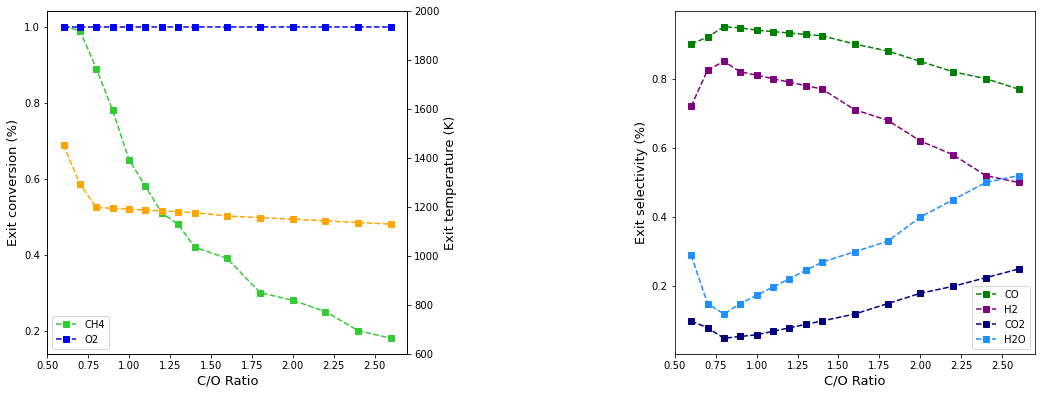

In [5]:
fig